<a href="https://colab.research.google.com/github/NaiaraSPinto/VegMapper/blob/devel-calval/calval/create_trainref_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculating Sample Sizes for Land Cover Assessment

This notebook walks through steps to calculate sample size and download sample points to assess accuracy of a land cover strata layer. 

In our example, we will be calculating sample sizes for presence and absence of oil palm fields in Ucayali, Peru. The notebook can calculate reference sample sizes, or reference + training/validation sample sizes. 

This notebook requires the following files/information:
- A land cover strata image including classes of **presence** and **absence** for the category of interest. The strata image should be a Google Earth Engine (GEE) image asset of integer type. 
- A pair of lists for user defined **presence** and **absence** categories. 
- A sampling method with its sampling parameters (see examples)
- A Google Drive account for exporting the final shapefile and CSV files.

The final sample points are exported in Collect Earth Online (CEO) format.

# Overview of Steps

0. Install packages and set project options
1. Set up and analyze strata layers for category statistics
2. Visually examine the strata layer in this code
3. Determine the **presence** and **Absence** sample size using one of three available methods.
4. Include Training/Validation requirements
5. Distribute sample points among sub-classes using weights
6. Perform sampling on GEE.
7. Display samples over strata (all classes). Print out # of samples per class to confirm. 
8. Export samples to Google Drive.
9. Import CSV from Google Drive, and reformat to CEO format.
10. Export reformatted CSV in CEO format.

### Workflow Diagram
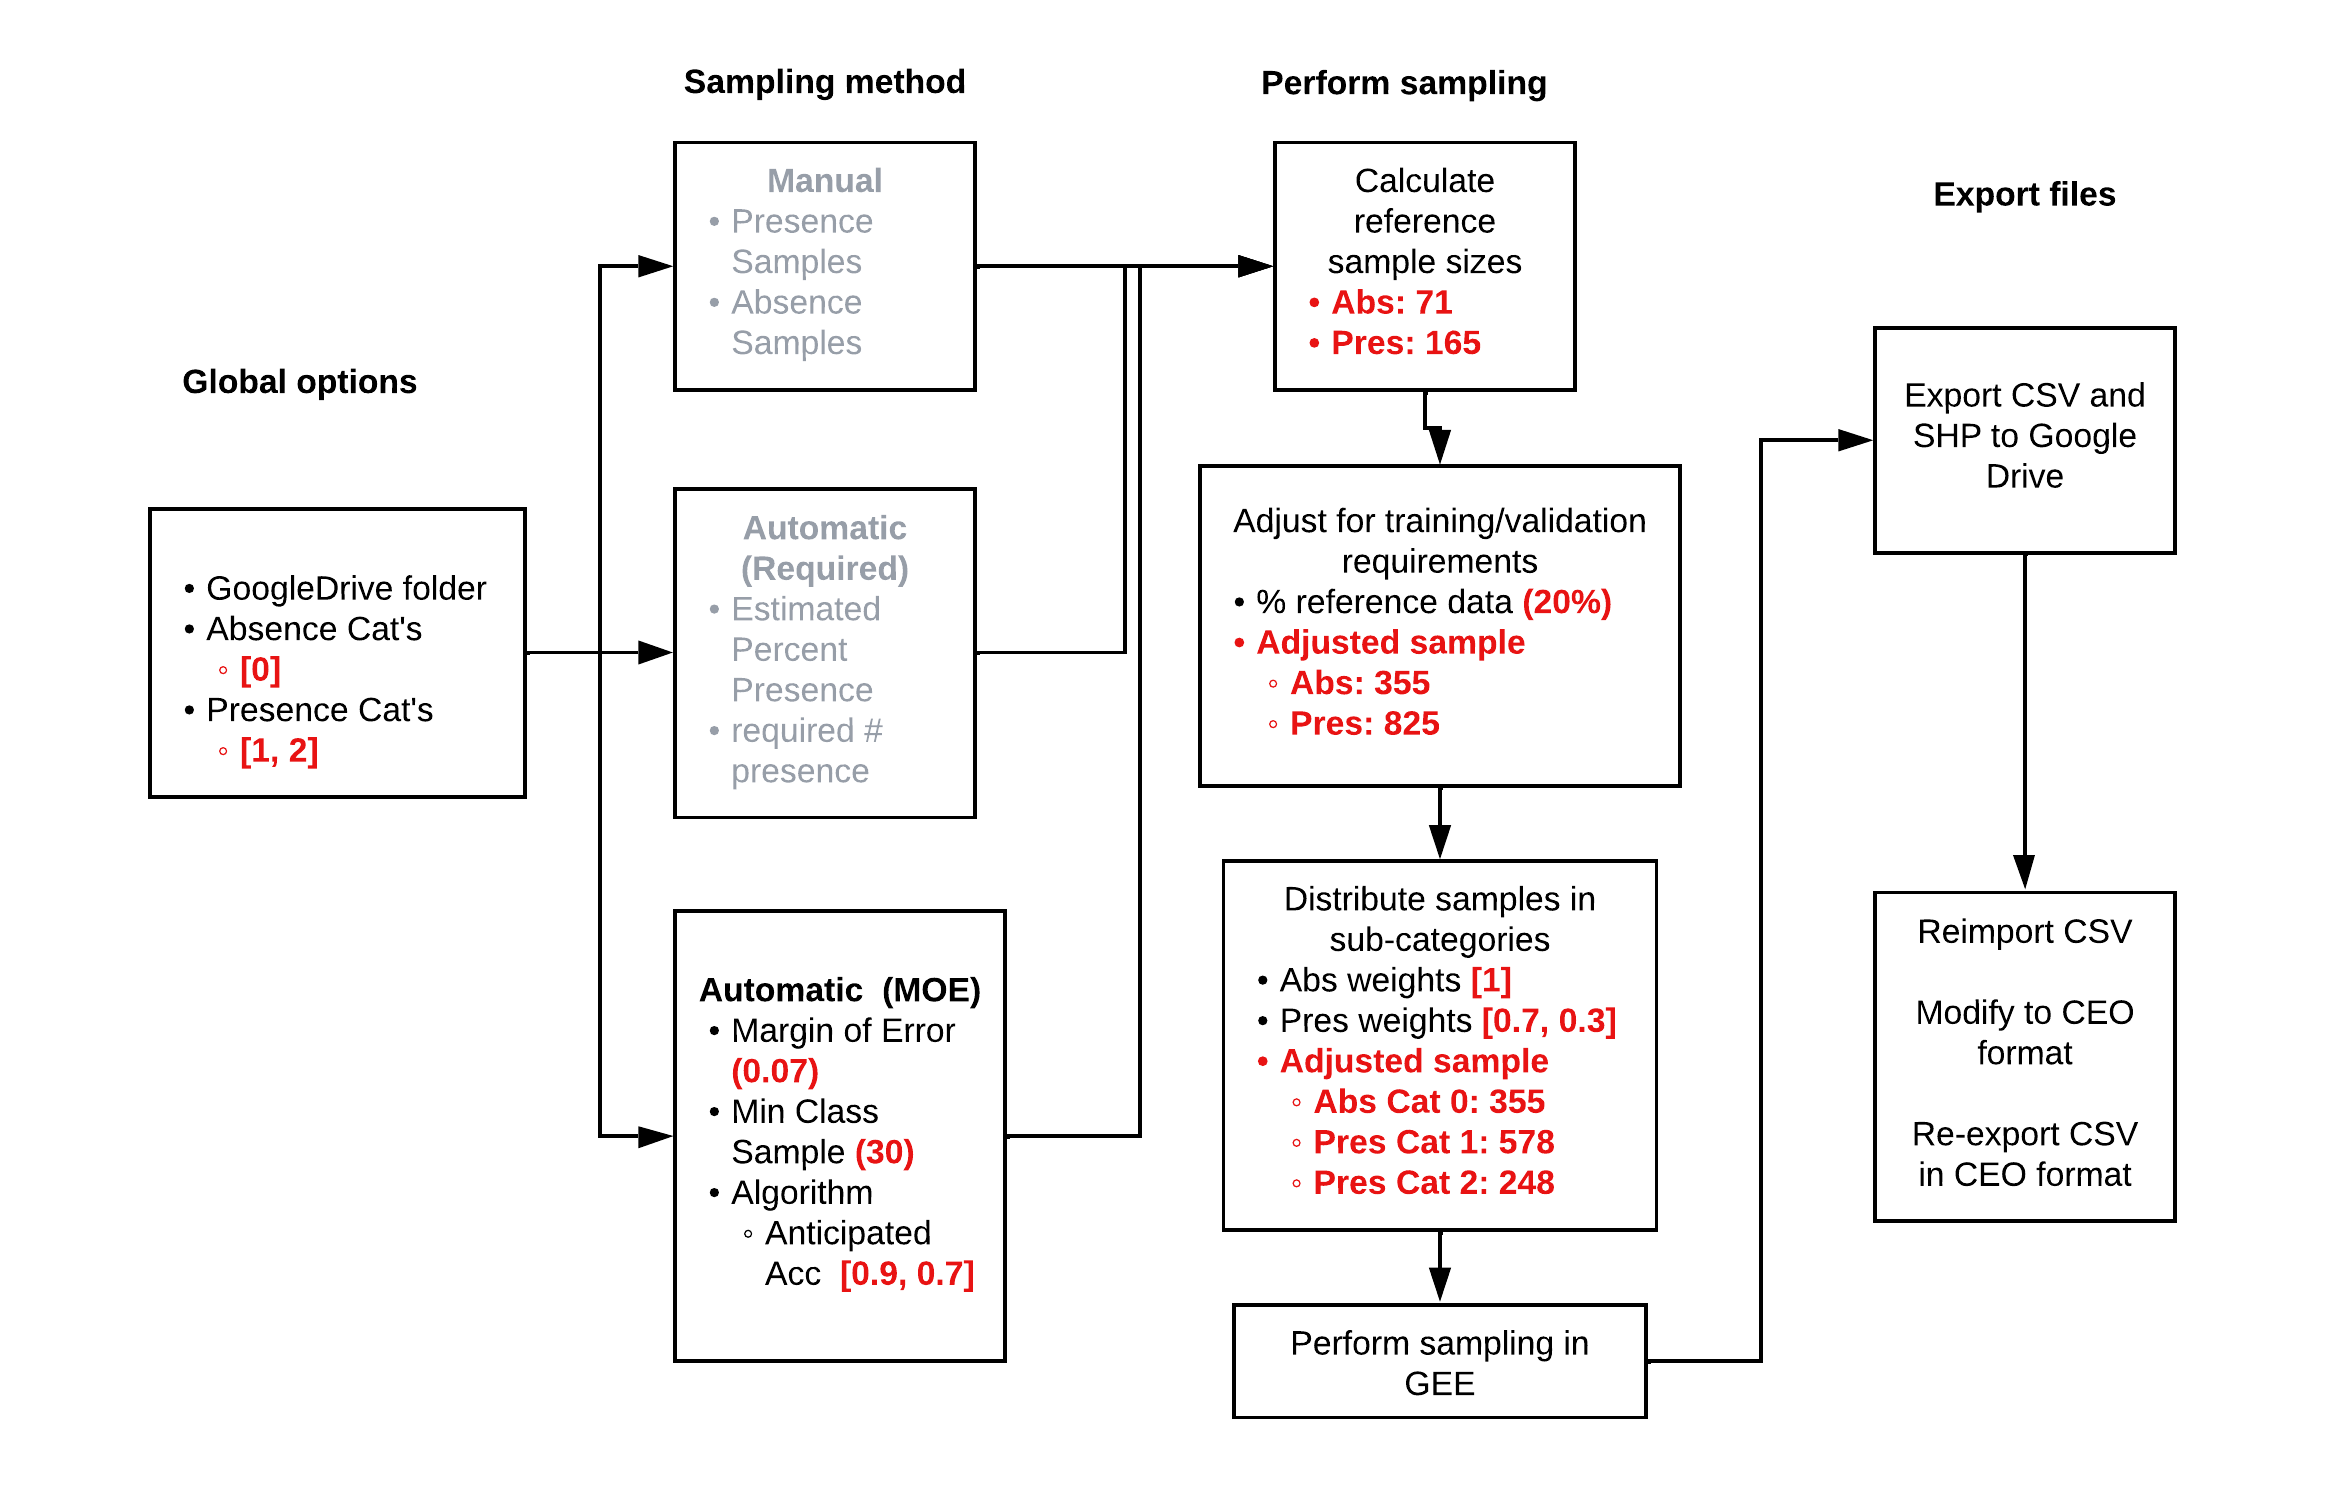

# Earth Engine Python API Colab Setup

Several libraries are required to be loaded to run this notebook. 

In addition, you need to authenticate your Google account to load data from Google Earth Engine (GEE).



### Import API and get credentials

These steps must be completed for each new Colab session, if you restart your Colab kernel, or if your Colab virtual machine is recycled due to inactivity.

Run the following cell to import the API into your session. 

**Note**: On first run you might get an error installing the `geemap` map package related to this message:

> AttributeError: module 'tornado.ioloop' has no attribute '_Selectable'

If that occurs, restart the runtime and run the cell below again.  The problem should clear

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
clone_path = "/content/gdrive/MyDrive/VegMapper/VegMapper"
git_path = 'https://github.com/SitianXiong/VegMapper.git'
#!rm -r VegMapper
!git clone -b "dev-calval-simplify" "{git_path}"

ModuleNotFoundError: No module named 'google'

In [1]:
import ee
import subprocess
import os

try:
    import geemap
except ImportError:
    print('geemap package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

try:
    import geetools
except ImportError:
    print('geetools package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geetools'])

import geemap
import geetools
import pprint
import pandas as pd
import numpy as np
from numpy.ma.core import sqrt
from scipy.stats import norm
import time 
import traitlets as _traitlets
from google.colab import drive
import json 
from datetime import datetime as dt

import logging as log
from sample_utils import *
#from VegMapper.calval.sample_utils import *
#from VegMapper.calval.labele_utils import *

/home/sitian/anaconda3/envs/rgee/lib/python3.8/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


### Authenticate GEE account.

You have two options for authentication. Option 1 requires some initial configuration effort, but once set up, you can authenticate the account by running the code without the need for point-and-click interaction in a popup browser. Option 2, on the other hand, requires granting access in a popup browser, then copy and paste authorization code each time you run the code.

Option 1: You can use a private key file for authentication. See this guide:
https://developers.google.com/earth-engine/guides/service_account#create-a-private-key-for-the-service-account  
or search in ChatGPT like "How can I authenticate a Google Earth Engine (GEE) account using a private key?"

In [2]:
credentials = ee.ServiceAccountCredentials('', key_file="zamlc2020unet-b07cf47b4cd8.json")
ee.Initialize(credentials)

Option 2: Run the following cell to authenticate your GEE account. You will need to click through several screens, allow access to your Google account, and then copy and paste your **Authorization code**, and press Enter.

In [ ]:
# Trigger the authentication flow.
# ee.Authenticate()
# # Initialize the library.
# ee.Initialize()

/home/sitian/anaconda3/envs/rgee/lib/python3.8/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=IT3NDd3bZwC-PTFiVJUiUHdhkfoVBkWb8nXvyjAv4uE&tc=mdgv7SPE5apHX0XOXBgbRBWuNX5L_FBkmD4sWwHksLA&cc=wwC92SN_E5oW2xuuHrBS_t2UBVpC8wkJtuE_9EVlg1o

The authorization workflow will generate a code, which you should paste in the box below.


# 1. Set up and analyze strata layers for category statistics

The code below imports a strata image from a Google Earth Engine (GEE) asset that contains land cover information from Ucayali, Peru. Then, the code retrieves the metadata of this image and calculates the category statistics.

The function analyze)strata_image() returns three variables:

strata: The strata image (an ee.Image object).
strata_df: The category statistics (a Pandas dataframe).
misc: A Python dictionary containing miscellaneous information such as minimum and maximum category values, bounding box (bbox), and scale.


In [3]:
strata, strata_df, misc = analyze_strata_image("users/michaeljcecil/Updated_Strata_v2")

Retriving GEE image...
Accessing image metadata...
Analyzing image categories...
Done!


# 2. Visually examine the strata layer.

The code below displays the strata image that we just imported from step 1. We will use the variable **strata** and **misc**.

In [4]:
# display the strata map with default palette
display(strata, misc)

# You can also change the color by adding your coustomized palette
#display(strata, misc, palette=['000000', '111111', '222222','333333', 'e32a1c', 'fdcf6f','1f28b4'])

Map(center=[-9.354459533546633, -73.2212695578606], controls=(WidgetControl(options=['position', 'transparent_…

# 3. Determine the **presence** and **Absence** sample size using one of three available methods.

Depending on the sampling design method, we may choose to specify the sample size for presence and absence either arbitrarily or based on prior knowledge from the strata image. If the latter approach is chosen, and if there are multiple categories considered as either presence or absence, we would need to consolidate those multiple categories into distinct presence and absence categories.


In [6]:
# in this function
# First, save a copy of this original multi-category before we consolidate to binary
strata_df_mltcat = strata_df.copy()

# absence and presence categories
absenceCats, presenceCats = [5], [1, 2]

# consolidate multi-categories to binary presence absence
strata_df_bincat = consolidate(strata_df, absenceCats, presenceCats)

print(strata_df_bincat)

   Cat  pixel_ct  pct_area
0    0    133358    93.398
1    1      9426     6.602


# 3. Calculate binary reference sample size

### Sampling method: Manual
This method uses arbitary sample size for presence and absence from user input.

In [11]:
strata_df_bincat = manual(strata_df_bincat, absenceSamples=1000, presenceSamples=1000)
print(strata_df_bincat)

   Cat  pixel_ct  pct_area  nh_adjusted
0    0    133358    93.398         1000
1    1      9426     6.602         1000


### Sampling method: Automatic

In [13]:
strata_df_bincat = automatic_requiredNumber(strata_df_bincat, 1000, 0.6, 1000, 1)
print(strata_df_bincat)

   Cat  pixel_ct  pct_area  nh_adjusted
0    0    133358    93.398         1000
1    1      9426     6.602         1667


### Sampling method: MOE

In [7]:
cfg_StehmanFoody = {"MarginOfError":0.07,
                    "ConfidenceLevel":0.95,
                    "MinimumClassSample":30,
                    "anticipatedAcc":[0.90, 0.7]}

strata_df_bincat = automatic_moe(strata_df_bincat, MOE_Algorithm="StehmanFoody", **cfg_StehmanFoody)
print(strata_df_bincat)

Using Stehman Foody
   Cat  pixel_ct  pct_area    p   nh  nh_adjusted
0    0    133358    93.398  0.9   70           70
1    1      9426     6.602  0.7  164          164


In [24]:
##This is how you use Olofsson method 
cfg_Olofsson = {"MarginOfError":0.07,
                "ConfidenceLevel":0.95,
                "MinimumClassSample":30,
                "CategoryOfInterest":1,
                "mappingAcc":[0.000000001, 0.7]}

strata_df_bincat = automatic_moe(strata_df_bincat, MOE_Algorithm="Olofsson", **cfg_Olofsson)
print(strata_df_bincat)

Using Olofsson
total sample size  164.95554775164945
   Cat  pixel_ct  pct_area            qh       wh       SDh  SDh_x_wh   nh  \
0    0    133358    93.398  1.000000e-09  0.93398  0.000032  0.000030  154   
1    1      9426     6.602  7.000000e-01  0.06602  0.458258  0.030254   10   

   nh_adjusted  
0          154  
1           30  


# 4. Include Training/Validation requirements

This code adjusts sample size based on training/validation requirements.

In [26]:
(strata_df_bincat['nh_adjusted']/0.2).astype(int).tolist()

[770, 150]

# 5. Distribute the number of sample points among sub-classes

This code distributes the absence and presence samples among sub-categories, based on the **absenceSampleWeights** and **presenceSampleWeights** parameters.


In [8]:
# distribute sample in strata_df_mltcat
strata_df_mltcat = distribute_sample(
    strata_df_bincat,
    strata_df_mltcat,
    absenceCats,
    presenceCats,
    absenceSampleWeights=[1],
    presenceSampleWeights=[0.3, 0.7])

print(strata_df_mltcat)

distributing sample size for sub-classes...
   Cat  pixel_ct  nh_final
0    1      4507        49
1    2      4919       114
2    5    133358        70


We want to include the categories that are not considered in our sample design because the GEE stratifiedSample() function requires an explicit specification of 0 for categories that are not of interest.


In [9]:
strata_df_mltcat = unwant_cat_samples_zero(strata_df_mltcat)
print(strata_df_mltcat)

   Cat  pixel_ct  nh_final
0    1    4507.0        49
1    2    4919.0       114
2    3       NaN         0
3    4       NaN         0
4    5  133358.0        70


# 6. Perform Sampling in GEE

This code uses the GEE API to calculate the location of all sample points. 

These points are then displayed in a map, with presence samples in <font color='red'>**red**</font> and absence samples in <font color='blue'>**blue**</font>.

In [10]:
seed = 9999

# numPoints=10 is a placeholder specification. It will be overwritten by classPoints,
# which contains the sample size for sampling.
samples = strata.stratifiedSample(
  numPoints = 10,
  classBand= misc['classBand'],
  projection= 'EPSG:3857',
  classValues= ee.List(strata_df_mltcat['Cat'].tolist()),
  classPoints= ee.List(strata_df_mltcat['nh_final'].tolist()),
  geometries= True,
  scale= 30,
  seed= seed,
  tileScale= 1)

# 7. Confirm # of samples per category

This code iterates through each class of the original strata layer and prints the number of points per class. 

**Note that some if a category does not have enough pixels to meet the sample size requirements, then there may be fewer sample points for this category.**

In [11]:
samples_presence = samples.filter(ee.Filter.inList(misc['classBand'], presenceCats))
samples_absence = samples.filter(ee.Filter.inList(misc['classBand'], absenceCats))
display_samples(strata,misc, samples_presence, samples_absence)

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [15]:
# Get a list of feature dictionaries with lat and lon properties
samples_df = sampleFC_to_csv(samples)
timestamp = dt.now().strftime("%Y_%m_%d_%H%M%S")

# 8. Export samples to Google Drive

This code exports the sample points to your Google Drive folder. The points are exported as a shapefile "sample_points_SHP", and as a CSV file "sample_points_CSV". 



First, mount your Google Drive folder and create the directory for output (this step is necessary otherwise the EE functions will write the same folder twice)

In [12]:
## mount your Google Drive to access files
drive.mount('/content/drive')

KeyError: 'CLOUDSDK_CONFIG'

Create output folder

In [ ]:
outpath = f"/content/drive/MyDrive/{gdrive_folder}"
if not os.path.isdir(outpath):
    print(f"Creating output folder {gdrive_folder}")
    os.makedirs(outpath, exist_ok=True)

The "Polling for task" message displays every 5 seconds. Once it stops displaying, your files should be ready. 

In [ ]:
samples_df.to_csv('test_csv_output.csv')